### Protein Family Classification

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from attrdict import AttrDict
from lazy import lazy

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
family_classification_metadata = pd.read_table('data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_LIV,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [7]:
CLASSES_NUMBER = 100
EMBED_LENGTH = 100

most_frequent_families_names = family_classification_metadata['FamilyID'].value_counts().index.values[:CLASSES_NUMBER]
families_ids = dict(zip(most_frequent_families_names, range(len(most_frequent_families_names))))

In [8]:
embed_matrix = pd.read_csv('data/protVec_100d_3grams.csv', sep='\\t', header=None, engine='python', index_col=0)
trigrams = embed_matrix.index.tolist()
trigrams_ids = dict(zip(trigrams, range(len(trigrams))))
trigrams_embeddings = dict(zip(trigrams, [np.array(embed_matrix.values[i]) for i in range(len(trigrams))]))
UNKNOWN = '<unk>'

In [9]:
MAX_LENGTH = family_classification_sequences['Sequences'].str.len().max() // 3

def get_sequence_embedding(sequence):
    embedding = []
    for j in range(0, len(sequence) - 2, 3):
        if sequence[j : j + 3] in trigrams_embeddings:
            embedding.append(trigrams_embeddings[sequence[j : j + 3]])
        else:
            embedding.append(trigrams_embeddings[UNKNOWN])
    remain_length = MAX_LENGTH - len(embedding)
    for j in range(remain_length):
        embedding.append(np.zeros(EMBED_LENGTH, dtype=np.float32))
    return np.array(embedding)      

def get_family_sequence(i):
    family = family_classification_metadata['FamilyID'][i]
    return families_ids[family], get_sequence_embedding(family_classification_sequences['Sequences'][i])

indices = []
for i in range(len(family_classification_metadata)):
    family = family_classification_metadata['FamilyID'][i]
    if family in most_frequent_families_names:
        indices.append(i)

TEST_RATIO = 0.2
train_indices, test_indices = train_test_split(indices, test_size=TEST_RATIO)

In [10]:
tsne = TSNE(n_components=2)
tsne_df = pd.DataFrame(tsne.fit_transform(embed_matrix), columns=['x0', 'x1'])
tsne_df.head()

,x0,x1
0,6.262406,-2.486669
1,6.085167,-3.007534
2,3.029899,-5.880244
3,6.125346,-2.706588
4,6.109176,-2.829507


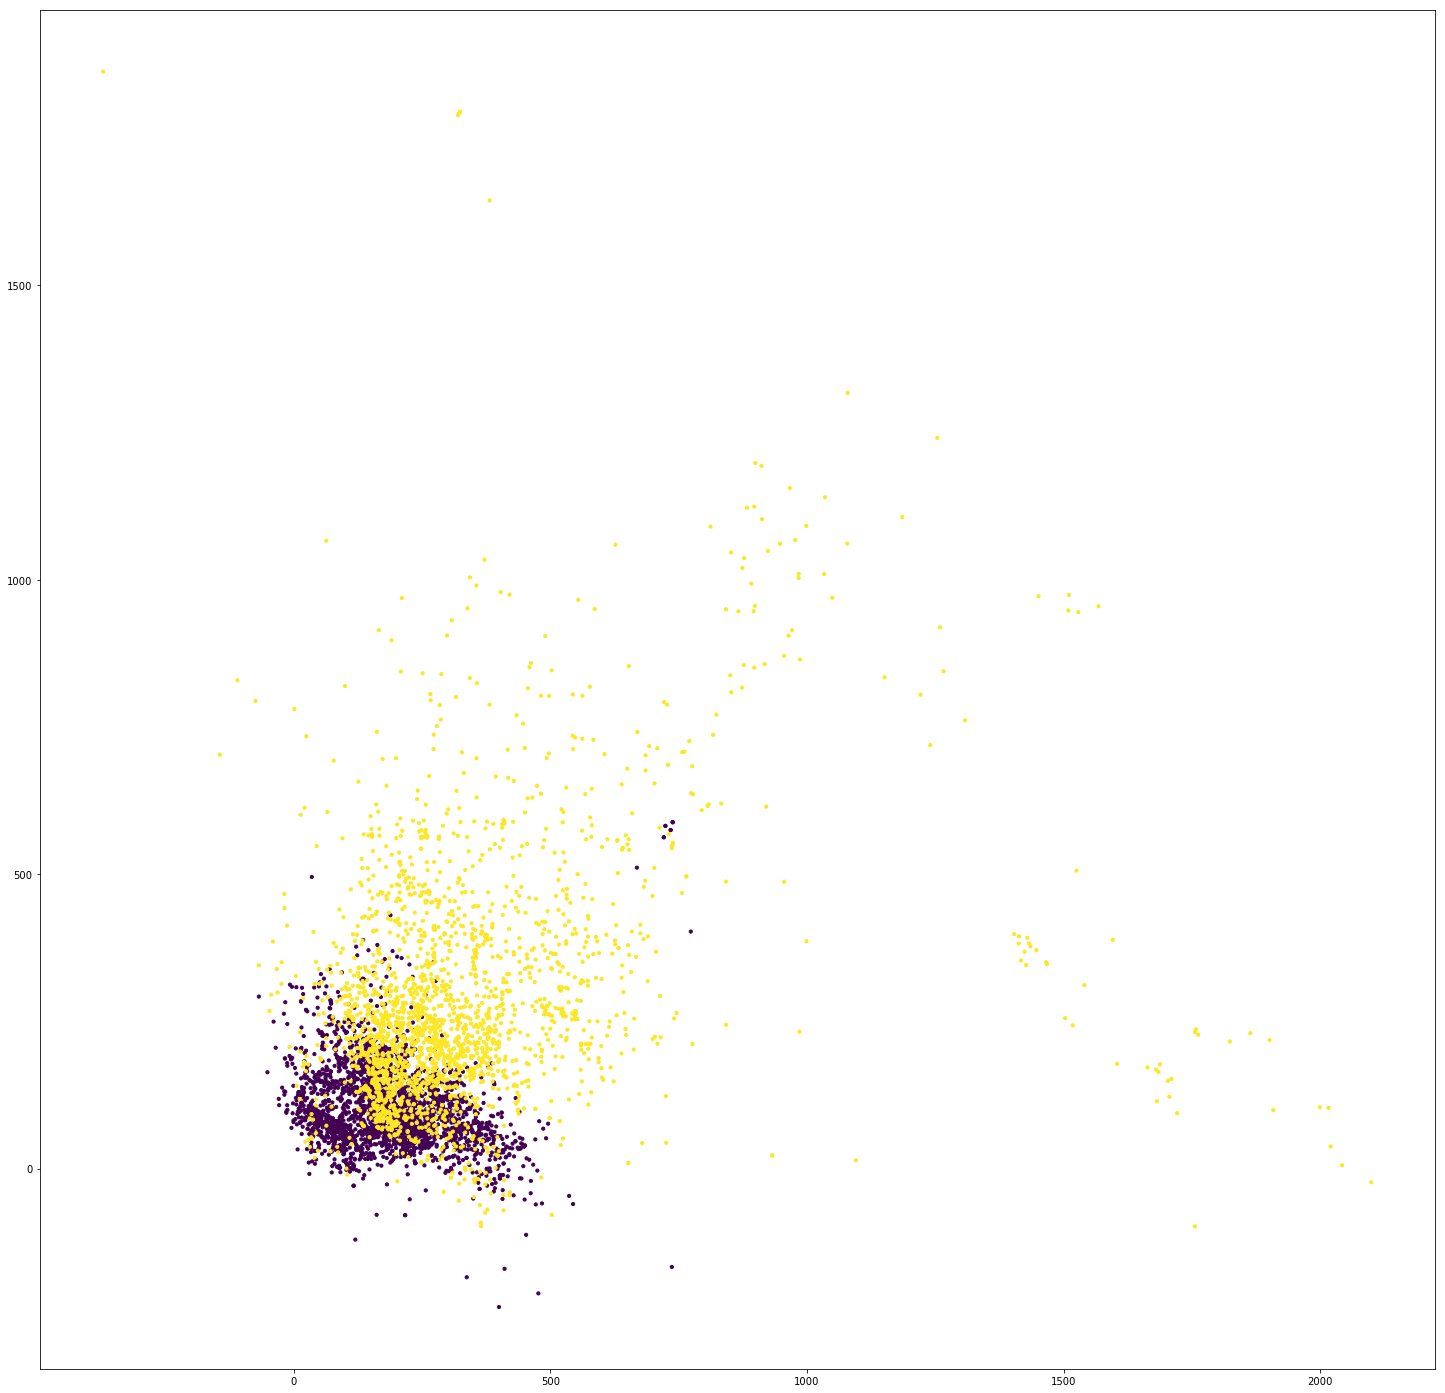

In [11]:
res = [[], [], []]
for class_index in range(2):
    for i in range(len(family_classification_metadata)):
        if (family_classification_metadata['FamilyID'][i] == most_frequent_families_names[class_index]):
            sequence = family_classification_sequences['Sequences'][i]
            sum = [0, 0]
            columns = ['x0', 'x1']
            for j in range(0, len(sequence) - 2, 3):
                if sequence[j:j + 3] in trigrams_embeddings:
                    id = trigrams_ids[sequence[j:j + 3]]
                for k in range(2):
                    sum[k] += tsne_df[columns[k]][id]               
            for k in range(2):
                res[k].append(sum[k])
            res[2].append(class_index)

plt.figure(figsize=(25, 25))
plt.scatter(res[0], res[1], c=res[2], s=10)
plt.show()                            

In [12]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, CLASSES_NUMBER])
            self.target
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [13]:
BATCH_SIZE = 64

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.AdamOptimizer(0.002),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_LENGTH,
    embed_length=EMBED_LENGTH
)

In [14]:
def generate_batch(indices):
    for i in range(0, len(indices), BATCH_SIZE):
        if i + BATCH_SIZE > len(indices):
            return
        x = np.zeros((BATCH_SIZE, MAX_LENGTH, EMBED_LENGTH))
        target = np.zeros((BATCH_SIZE, CLASSES_NUMBER))
        for j in range(BATCH_SIZE):
            family_id, embedding = get_family_sequence(indices[i + j])
            x[j] = embedding
            target[j, family_id] = 1
        yield x, target 

train_batches = generate_batch(train_indices)
test_batches = generate_batch(test_indices)

In [15]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'proteins')

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
saver = tf.train.Saver()

with tf.Session() as sess:
    try:
        print("Trying to restore last checkpoint ...")
        saver.restore(sess, save_path="checkpoints/proteins")
    except:
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('graphs', sess.graph)

    for index, batch in enumerate(train_batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print(str(index) + ': ' + str(error))
        if index % 10 == 0:
            summary_writer.add_summary(summary_str, index)
        if index % 100 == 0:
            saver.save(sess, save_path, index)
            print("Saved checkpoint.") 
            
    sum_error = 0
    test_batches_length = 0
    for index, batch in enumerate(test_batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error = sess.run(model.error, feed)
        sum_error += error
        test_batches_length += 1
        print(str(index) + ': ' + str(error))  
    print('Test error: ' + str(sum_error / test_batches_length))          

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/proteins
Failed to restore checkpoint. Initializing variables instead.
0: 0.984375
Saved checkpoint.
1: 1.0
2: 0.96875
3: 0.953125
4: 0.96875
5: 0.984375
6: 0.921875
7: 0.953125
8: 0.921875
9: 1.0
10: 1.0
11: 0.9375
12: 0.984375
13: 0.984375
14: 0.984375
15: 0.984375
16: 0.953125
17: 1.0
18: 0.9375
19: 0.953125
20: 0.96875
21: 0.96875
22: 0.984375
23: 0.984375
24: 0.953125
25: 0.984375
26: 0.9375
27: 1.0
28: 0.953125
29: 1.0
30: 1.0
31: 0.96875
32: 0.984375
33: 1.0
34: 0.953125
35: 0.953125
36: 0.953125
37: 0.96875
38: 0.953125
39: 0.984375
40: 0.921875
41: 0.984375
42: 0.9375
43: 0.921875
44: 0.96875
45: 0.984375
46: 0.890625
47: 0.96875
48: 0.90625
49: 0.96875
50: 0.953125
51: 0.921875
52: 0.9375
53: 0.96875
54: 0.953125
55: 0.953125
56: 0.953125
57: 0.9375
58: 0.953125
59: 0.953125
60: 0.953125
61: 0.984375
62: 0.90625
63: 0.921875
64: 0.921875
65: 0.9375
66: 0.921875
67: 0.96875
68: 0.953125

613: 0.59375
614: 0.421875
615: 0.46875
616: 0.609375
617: 0.609375
618: 0.5
619: 0.578125
620: 0.421875
621: 0.609375
622: 0.609375
623: 0.515625
624: 0.46875
625: 0.609375
626: 0.59375
627: 0.40625
628: 0.46875
629: 0.546875
630: 0.53125
631: 0.5
632: 0.5
633: 0.46875
634: 0.515625
635: 0.453125
636: 0.53125
637: 0.515625
638: 0.5625
639: 0.53125
640: 0.546875
641: 0.515625
642: 0.53125
643: 0.40625
644: 0.46875
645: 0.40625
646: 0.390625
647: 0.671875
648: 0.359375
649: 0.5625
650: 0.46875
651: 0.46875
652: 0.359375
653: 0.453125
654: 0.34375
655: 0.5
656: 0.40625
657: 0.5
658: 0.421875
659: 0.453125
660: 0.328125
661: 0.5
662: 0.53125
663: 0.4375
664: 0.4375
665: 0.4375
666: 0.5
667: 0.390625
668: 0.421875
669: 0.53125
670: 0.375
671: 0.5625
672: 0.546875
673: 0.46875
674: 0.453125
675: 0.5
676: 0.421875
677: 0.5
678: 0.515625
679: 0.453125
680: 0.484375
681: 0.4375
682: 0.453125
683: 0.484375
684: 0.5
685: 0.375
686: 0.4375
687: 0.390625
688: 0.578125
689: 0.453125
690: 0.421875
6

32: 0.1875
33: 0.296875
34: 0.375
35: 0.25
36: 0.28125
37: 0.265625
38: 0.390625
39: 0.28125
40: 0.375
41: 0.34375
42: 0.390625
43: 0.21875
44: 0.328125
45: 0.265625
46: 0.203125
47: 0.328125
48: 0.3125
49: 0.265625
50: 0.3125
51: 0.375
52: 0.234375
53: 0.21875
54: 0.25
55: 0.21875
56: 0.265625
57: 0.265625
58: 0.328125
59: 0.25
60: 0.359375
61: 0.25
62: 0.328125
63: 0.265625
64: 0.359375
65: 0.203125
66: 0.3125
67: 0.234375
68: 0.375
69: 0.328125
70: 0.296875
71: 0.40625
72: 0.234375
73: 0.328125
74: 0.296875
75: 0.265625
76: 0.265625
77: 0.3125
78: 0.34375
79: 0.25
80: 0.34375
81: 0.359375
82: 0.296875
83: 0.25
84: 0.296875
85: 0.390625
86: 0.296875
87: 0.34375
88: 0.34375
89: 0.296875
90: 0.1875
91: 0.390625
92: 0.28125
93: 0.328125
94: 0.265625
95: 0.328125
96: 0.28125
97: 0.34375
98: 0.3125
99: 0.34375
100: 0.265625
101: 0.328125
102: 0.3125
103: 0.28125
104: 0.28125
105: 0.328125
106: 0.421875
107: 0.296875
108: 0.296875
109: 0.25
110: 0.25
111: 0.3125
112: 0.265625
113: 0.296875

### RandomForestClassifier

In [17]:
def generate_data(indices):
    x = np.zeros((len(indices), EMBED_LENGTH))
    y = np.zeros(len(indices))
    for i in range(len(indices)):
        family_id, embedding = get_family_sequence(indices[i])
        x[i] = np.sum(embedding, axis=0)
        y[i] = family_id        
    return x, y

X_train, y_train = generate_data(train_indices)
X_test, y_test = generate_data(test_indices)

xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]
nrounds = 5
params = {
    'objective': 'multi:softmax',
    'eta': 1,
    'silent': 1,
    'max_depth': 5,
    'num_class': CLASSES_NUMBER,
    'nthread': 10
}
booster = xgb.train(params, xgb_train, nrounds, watchlist)

[0]	train-merror:0.400144	test-merror:0.442944
[1]	train-merror:0.424603	test-merror:0.473513
[2]	train-merror:0.426147	test-merror:0.486233
[3]	train-merror:0.489066	test-merror:0.553287
[4]	train-merror:0.509861	test-merror:0.570875
